In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-segmentation/bank_transactions.csv


In [2]:
import pandas as pd
import numpy as np

import re

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import scipy.cluster.hierarchy as shc

In [3]:
try:
    from kneed import KneeLocator
except:    
    !pip install kneed
    from kneed import KneeLocator
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    !pip install-U yellowbrick
    from yellowbrick.cluster import KElbowVisualizer

In [4]:
try:
    import plotly.express as px
    import plotly.graph_objects as go
    
except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go

In [5]:
data = pd.read_csv("/kaggle/input/bank-customer-segmentation/bank_transactions.csv")
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [6]:
def check(df):
    l = []
    columns = df.columns
    for col in columns:
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns = ['columns','dtypes','nunique','sum_null']
    return df_check
check(data)

,columns,dtypes,nunique,sum_null
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount (INR),float64,93024,0


Text(0.5, 1.0, 'Frequency')

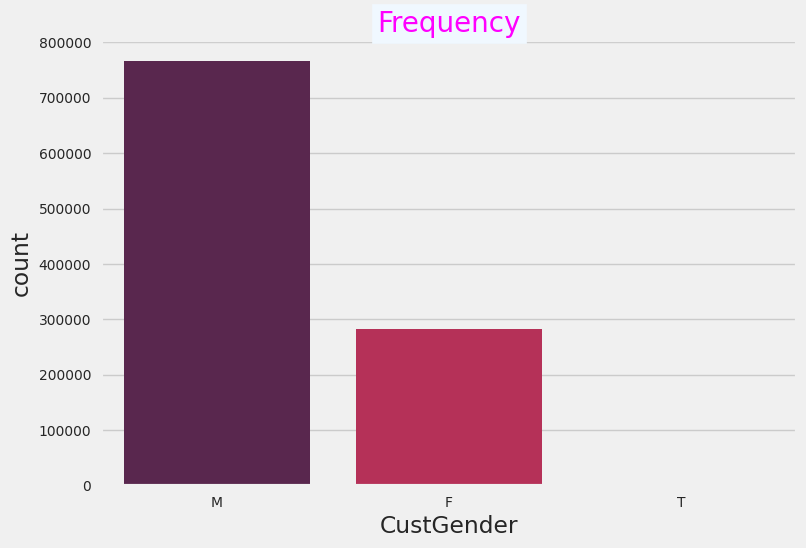

In [7]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='CustGender',data=data,palette='rocket',order=data['CustGender'].value_counts().index)

plt.title("Frequency",fontsize='20',backgroundcolor='AliceBlue',color='magenta')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [9]:
data.dropna(subset=['CustLocation','CustomerDOB','CustAccountBalance'],inplace = True)
data.shape

(1042651, 9)

In [10]:
check(data)

,columns,dtypes,nunique,sum_null
0,TransactionID,object,1042651,0
1,CustomerID,object,880115,0
2,CustomerDOB,object,17234,0
3,CustGender,object,3,1037
4,CustLocation,object,9278,0
5,CustAccountBalance,float64,160829,0
6,TransactionDate,object,55,0
7,TransactionTime,int64,81862,0
8,TransactionAmount (INR),float64,92448,0


In [11]:
data.fillna({
    "CustGender":'M'
},inplace=True)

In [12]:
data["CustomerDOB"]=pd.to_datetime(data["CustomerDOB"])
data["TransactionDate"]=pd.to_datetime(data["TransactionDate"])

data["CustomerAge"] = data["TransactionDate"].dt.year-data["CustomerDOB"].dt.year

/tmp/ipykernel_20/233682975.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["CustomerDOB"]=pd.to_datetime(data["CustomerDOB"])
/tmp/ipykernel_20/233682975.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["TransactionDate"]=pd.to_datetime(data["TransactionDate"])


In [13]:
data["CustomerAge"].unique()

array([ 22, -41,  20,  43,  28, -56,  24,  34,  32,  38, -52, 216,  27,
        25,  31,  23,  30, -51,  37,  39,  19,  33,  26,  36,  35, -50,
        29,  41,  21,  42, -55, -16, -43,  17, -49, -25, -38, -54,  40,
        -5, -53,  12, -27,  18, -35, -44, -40, -37, -31,  16, -48, -32,
       -46, -36, -39, -45, -20, -47, -26, -28, -22, -33, -42, -34, -30,
        14, -29, -21,   9,  15, -23, -24,   3,  13,  11,   6,   5, -17,
       -18, -11,  -3, -12, -14,   7, -15, -13, -19,   1,   0,  10,   8,
         4,  -7, -10,  -8,  -6,   2,  -4,  -9,  -2], dtype=int32)

In [14]:
data["TransactionDate1"]=data["TransactionDate"]
data["TransactionDate2"]=data["TransactionDate"]

In [15]:
RMF_data = data.groupby("CustomerID").agg({
    "TransactionID": "count",
    "CustGender":"first",
    "CustLocation":"first",
    "CustAccountBalance":"mean",
    "TransactionAmount (INR)":"mean",
    "CustomerAge":"max",
    "TransactionDate2":"max",
    "TransactionDate1":"min",
    "TransactionDate":"median"
})
RMF_data = RMF_data.reset_index()
RMF_data.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,33,2016-09-26,2016-09-08,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,32,2016-07-08,2016-01-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49,2016-08-18,2016-08-18,2016-08-18


In [16]:
RMF_data.shape

(880115, 10)

In [17]:
RMF_data.drop(columns=["CustomerID"],inplace=True)

In [18]:
RMF_data['Recency']=RMF_data['TransactionDate2']
RMF_data['TransactionDate1']

0        2016-09-08
1        2016-08-14
2        2016-01-08
3        2016-09-15
4        2016-08-18
            ...    
880110   2016-07-08
880111   2016-09-15
880112   2016-08-18
880113   2016-08-28
880114   2016-09-25
Name: TransactionDate1, Length: 880115, dtype: datetime64[ns]

In [19]:
RMF_data['Recency']=RMF_data['Recency'].astype(str)
RMF_data.head()

,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,33,2016-09-26,2016-09-08,2016-09-17,2016-09-26
1,1,M,MUMBAI,24204.490,1499.0,22,2016-08-14,2016-08-14,2016-08-14,2016-08-14
2,2,F,MUMBAI,100112.950,727.5,32,2016-07-08,2016-01-08,2016-04-08,2016-07-08
3,1,F,CHAMPARAN,496.180,30.0,26,2016-09-15,2016-09-15,2016-09-15,2016-09-15
4,1,M,KOLKATA,87058.650,5000.0,-49,2016-08-18,2016-08-18,2016-08-18,2016-08-18


In [20]:
RMF_data['Recency']=RMF_data['Recency'].apply(lambda x :re.search('\d+',x).group())
RMF_data['Recency']=RMF_data['Recency'].astype(int)

In [21]:
def rep_0(i):
    if i==0:
        return 1
    else:
        return i
    RMF_data['Recency']=RMF_data['Recency'].apply(rep_0)

In [22]:
RMF_data.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)
RMF_data.head(3)

,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,33,2016-09-17,2016
1,1,M,MUMBAI,24204.490,1499.0,22,2016-08-14,2016
2,2,F,MUMBAI,100112.950,727.5,32,2016-04-08,2016


In [23]:
RMF_data.rename(columns={"TransactionID":"Frequency"},inplace=True)

In [24]:
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency','CustAccountBalance','TransactionAmount (INR)','CustomerAge','Recency']
for i in cols:
        Q1 =RMF_data[i].quantile(0.25)
        Q3 =RMF_data[i].quantile(0.75)
        IQR = Q3-Q1
        lower = Q1-1.5*IQR
        upper = Q3*1.5*IQR
        num=RMF_data[(RMF_data[i] < lower)|(RMF_data[i] > upper)].shape[0]
        perc = (num / RMF_data.shape[0])*100
        lower_list.append(lower)
        upper_list.append(upper)
        num_list.append(num)
        perc_list.append(round(perc,2))
dic={'lower':lower_list,'upper':upper_list,'cutliers':num_list,'perc%':perc_list}
cutliers_df=pd.DataFrame(dic,index=['Frequency','CustAccountBalance','TransactionAmount (INR)','CustomerAge','Recency'])
cutliers_df

,lower,upper,cutliers,perc%
Frequency,1.0000,0.000000e+00,880115,100.0
CustAccountBalance,-78311.0400,5.159844e+09,0,0.0
TransactionAmount (INR),-1385.4825,1.956039e+06,0,0.0
CustomerAge,11.5000,4.590000e+02,60739,6.9
Recency,2016.0000,0.000000e+00,880115,100.0
